# 1 - Imports

In [1]:
import sys
sys.path.append('/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/scripts/')
import os
import argparse
import torchaudio
import torchaudio.functional as F
import torch
import IPython
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import pickle
import librosa 
import numpy as np
import random
import math
import librosa
import librosa.display
import seaborn as sns
import pandas as pd

from data import TrainDataset
from settings import TRAIN_DEFAULT_SETTINGS

# 2 - Functions

In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [3]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [4]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [5]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# 3 - Settings

In [6]:
default_params_dict = TRAIN_DEFAULT_SETTINGS
default_params_dict['train_labels_path'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/train/voxceleb1/sc_labels.ndx'
default_params_dict['train_data_dir'] = ['/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb1/dev/']
default_params_dict['valid_clients'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/valid/voxceleb1/clients.ndx'
default_params_dict['valid_impostors'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/valid/voxceleb1/impostors.ndx'
default_params_dict['valid_data_dir'] = ['/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb1/dev/']
default_params_dict['max_epochs'] = 2

train_params = argparse.Namespace(**default_params_dict)

# 4 - Data Processing

#### Load a Dataset item

In [7]:
from utils import format_sc_labels
from torch.utils.data import DataLoader

train_sc_labels_lines = format_sc_labels(
            labels_path = train_params.train_labels_path,
            prepend_directories = train_params.train_data_dir,
        )

dataset = TrainDataset(
            train_sc_labels_lines, 
            train_params,
            )

train_sc_labels_lines = format_sc_labels(
            labels_path = train_params.train_labels_path,
            prepend_directories = train_params.train_data_dir,
        )

utterance_tuple = train_sc_labels_lines[0].strip().split(' ')
utterance_path = utterance_tuple[0]
utterance_label = int(utterance_tuple[1])

# Load the audio into waveform
waveform, original_sample_rate = torchaudio.load(
    utterance_path)

# Resample to desired sample_rate
waveform = torchaudio.functional.resample(
    waveform, 
    orig_freq = original_sample_rate, 
    new_freq = 16000,
    )

if True:
    # Sample a random crop
    waveform = dataset.sample_random_waveform_crop(
        waveform,
        sample_rate = dataset.parameters.sample_rate,
        seconds_to_crop = 1 #dataset.parameters.random_crop_secs,
        )

if True:
    waveform = dataset.normalize_waveform(
        waveform,
        preemphasis_coefficient = dataset.parameters.pre_emph_coef,
        )
    
features = dataset.get_feature_vector(waveform)

print(f"features.shape: {features.shape}")

features.shape: torch.Size([97, 80])


In [8]:
1/0

ZeroDivisionError: division by zero

### Without normalization

In [10]:
df = pd.DataFrame(features.transpose(0, 1))
df_describe = df.describe()
df_describe

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.006631,0.004163,0.004665,0.010563,0.112619,0.294832,0.360887,0.370256,0.299034,0.228400,...,0.108248,0.169246,0.229220,0.235095,0.195935,0.172487,0.146393,0.128672,0.115128,0.126999
std,0.017013,0.006743,0.007041,0.021640,0.282544,1.035353,1.084514,1.405397,1.208646,0.868674,...,0.428557,0.443221,0.649338,0.845648,0.790049,0.547706,0.361897,0.285333,0.283020,0.362252
min,0.000043,0.000068,0.000072,0.000168,0.000069,0.000054,0.000044,0.000026,0.000018,0.000019,...,0.000079,0.000112,0.000074,0.000023,0.000025,0.000047,0.000172,0.000028,0.000003,0.000008
25%,0.000455,0.000297,0.000590,0.001031,0.001217,0.002960,0.002282,0.002211,0.001901,0.002382,...,0.002302,0.003305,0.008282,0.003819,0.003868,0.002966,0.003767,0.006122,0.005029,0.005914
50%,0.002084,0.001551,0.001517,0.002321,0.005044,0.013501,0.009058,0.017066,0.014881,0.011768,...,0.005717,0.014122,0.017681,0.026219,0.022287,0.023878,0.025891,0.024598,0.036892,0.023944
75%,0.004916,0.004134,0.005673,0.008500,0.027950,0.079153,0.066645,0.082536,0.081991,0.081666,...,0.023604,0.075610,0.107358,0.107348,0.096929,0.103429,0.105016,0.109596,0.077998,0.080017
max,0.120943,0.036184,0.032580,0.133925,1.762311,7.865118,6.395599,10.626882,9.296203,6.625076,...,2.902786,2.902725,4.346529,5.569929,5.476793,3.934865,2.294606,1.964563,2.153278,2.736321


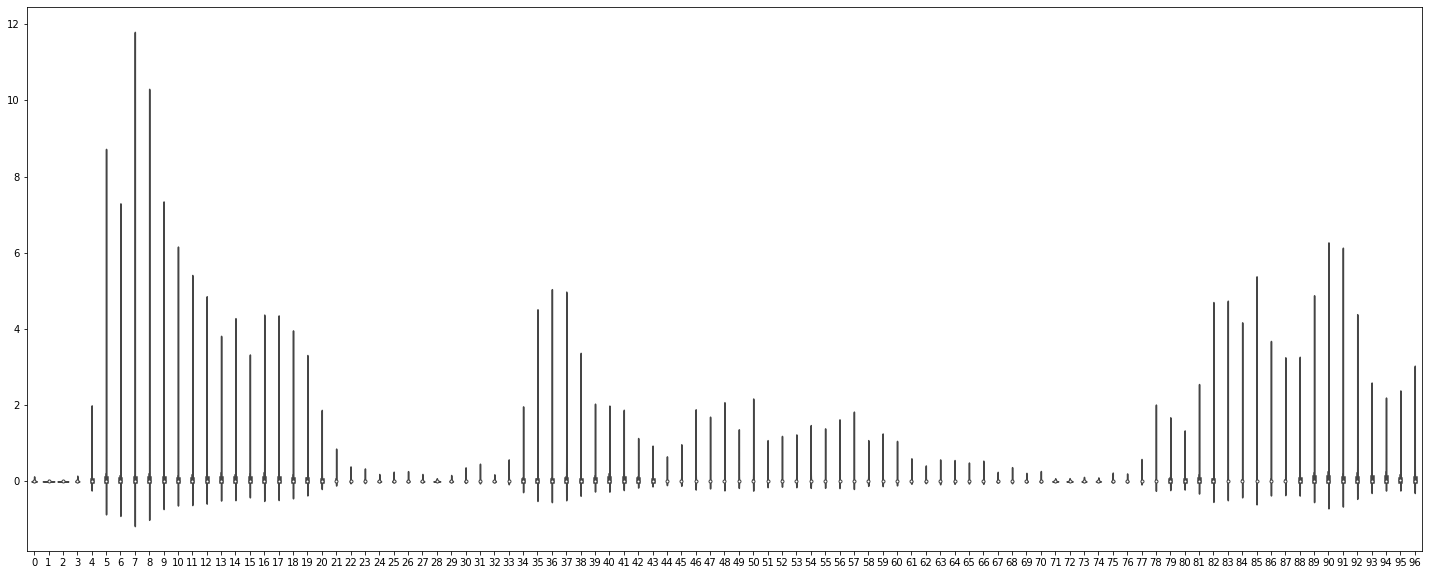

In [11]:
plt.figure(figsize=(25, 10))

sns.violinplot(features.transpose(0, 1))

plt.show()

### CMN

In [12]:
cmn_features = dataset.normalize_features(features, normalization = "cmn")

print(f"cmn_features.shape: {cmn_features.shape}")

cmn_features.shape: torch.Size([97, 80])


In [13]:
df = pd.DataFrame(cmn_features.transpose(0, 1))
df_describe = df.describe()
df_describe

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-0.976503,-1.296492,-1.074225,-0.496060,0.389502,1.034250,1.023655,1.078936,0.895851,0.810946,...,0.544927,1.232300,1.583018,1.397958,1.267029,1.307494,1.373632,1.388258,1.234576,1.059124
std,1.098714,0.965356,1.106959,0.946118,0.961439,1.071458,1.183546,1.374481,1.523591,1.581617,...,1.046015,1.219103,1.169909,1.414836,1.477956,1.537653,1.563512,1.539008,1.870487,1.681890
min,-4.127083,-3.570419,-4.167556,-2.224072,-1.840907,-1.203596,-1.700277,-2.612558,-1.754169,-2.114045,...,-1.679255,-3.126259,-1.094326,-1.960295,-1.943758,-1.757456,-2.707658,-2.373926,-4.744942,-3.691568
25%,-1.568723,-1.970314,-1.908580,-1.037389,-0.061781,0.147846,0.140003,0.051921,-0.232840,-0.431114,...,-0.288523,0.358167,0.910612,0.288971,0.324227,0.121709,0.445722,0.361096,0.058597,-0.218113
50%,-0.748043,-1.205846,-1.072798,-0.501684,0.354972,1.150671,0.836825,0.992727,0.613926,0.493265,...,0.618788,1.337629,1.497794,1.541676,1.219838,1.122077,1.265572,1.415972,1.552115,1.397144
75%,-0.194389,-0.454312,-0.299661,0.017282,0.914601,1.818692,1.913565,1.897116,1.765936,1.847909,...,1.316101,1.955871,2.277863,2.300651,2.380152,2.626825,2.620749,2.514033,2.662984,2.172831
max,1.105917,0.813509,1.332785,1.795976,2.682894,3.474591,3.835288,4.659973,5.049154,4.937683,...,3.070558,3.778160,4.673689,4.633307,4.113869,4.830185,4.802998,4.259142,4.526916,4.755657


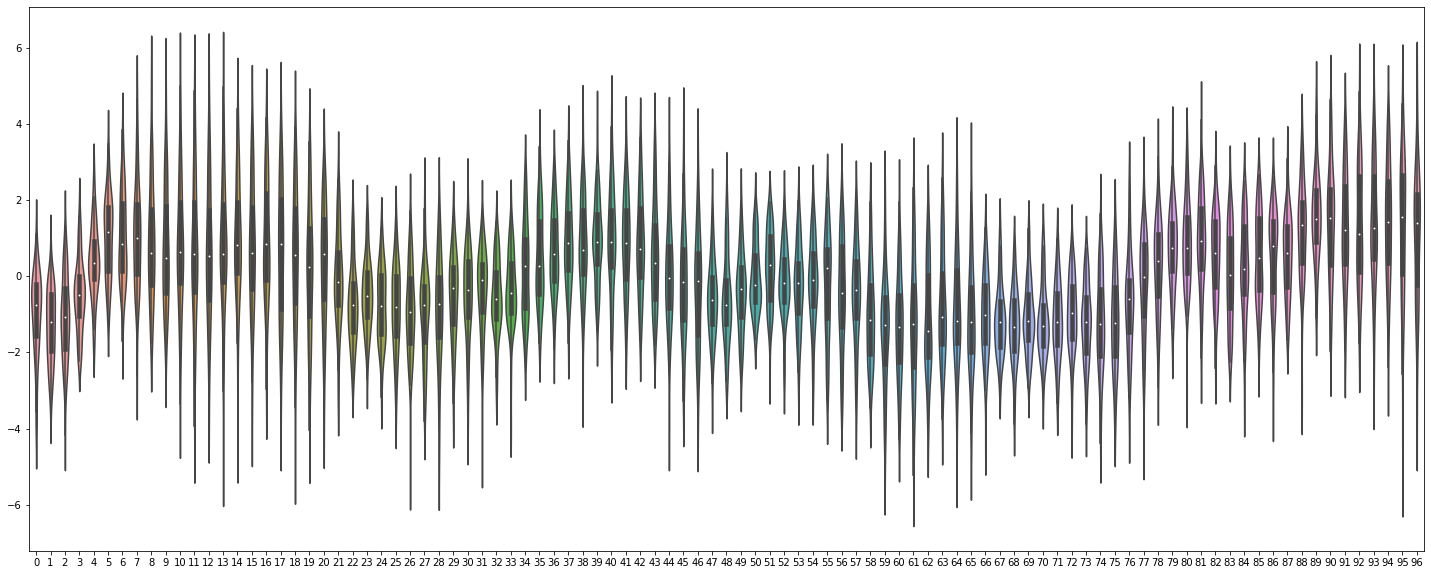

In [14]:
plt.figure(figsize=(25, 10))

sns.violinplot(cmn_features.transpose(0, 1))

plt.show()

### CMVN

In [15]:
cmvn_features = dataset.normalize_features(features, normalization = "cmvn")

In [16]:
df = pd.DataFrame(cmvn_features.transpose(0, 1))
df_describe = df.describe()
df_describe

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-0.653192,-0.900409,-0.744177,-0.320160,0.257790,0.660815,0.663146,0.658417,0.531766,0.470884,...,0.401123,0.820718,1.034422,0.875988,0.790820,0.810676,0.856227,0.861031,0.764900,0.657402
std,0.755818,0.695839,0.817465,0.677847,0.661133,0.689424,0.719218,0.832831,0.932497,0.968314,...,0.721308,0.736056,0.715553,0.882599,0.954848,0.955748,0.944691,0.944127,1.260590,1.139858
min,-3.091664,-2.841822,-3.558573,-1.828745,-1.512122,-1.109647,-0.949834,-1.490396,-1.361673,-1.393098,...,-1.294037,-1.475507,-0.934417,-1.088343,-1.585909,-1.433906,-1.871823,-1.584823,-3.167703,-2.464475
25%,-1.005942,-1.380306,-1.174005,-0.718587,-0.047550,0.098654,0.084619,0.038206,-0.156458,-0.277079,...,-0.160760,0.229147,0.665559,0.291283,0.226919,0.070983,0.301108,0.236103,0.032554,-0.198212
50%,-0.499372,-0.829761,-0.724376,-0.315514,0.237198,0.748539,0.615507,0.702974,0.480447,0.350555,...,0.406398,0.953232,1.108555,1.092605,0.801449,0.802557,0.941336,1.001759,1.072239,0.865447
75%,-0.098124,-0.312569,-0.184665,0.012004,0.539449,1.237638,1.305830,1.282231,1.200659,1.266745,...,0.932389,1.349260,1.372879,1.449751,1.440156,1.552750,1.556250,1.514394,1.703505,1.404984
max,1.035135,0.399915,0.807908,1.310959,1.627401,2.280177,2.047992,2.488362,2.696180,2.636656,...,1.854002,2.225840,2.687837,2.785554,2.644267,2.446456,2.514819,2.411629,2.818758,2.668252


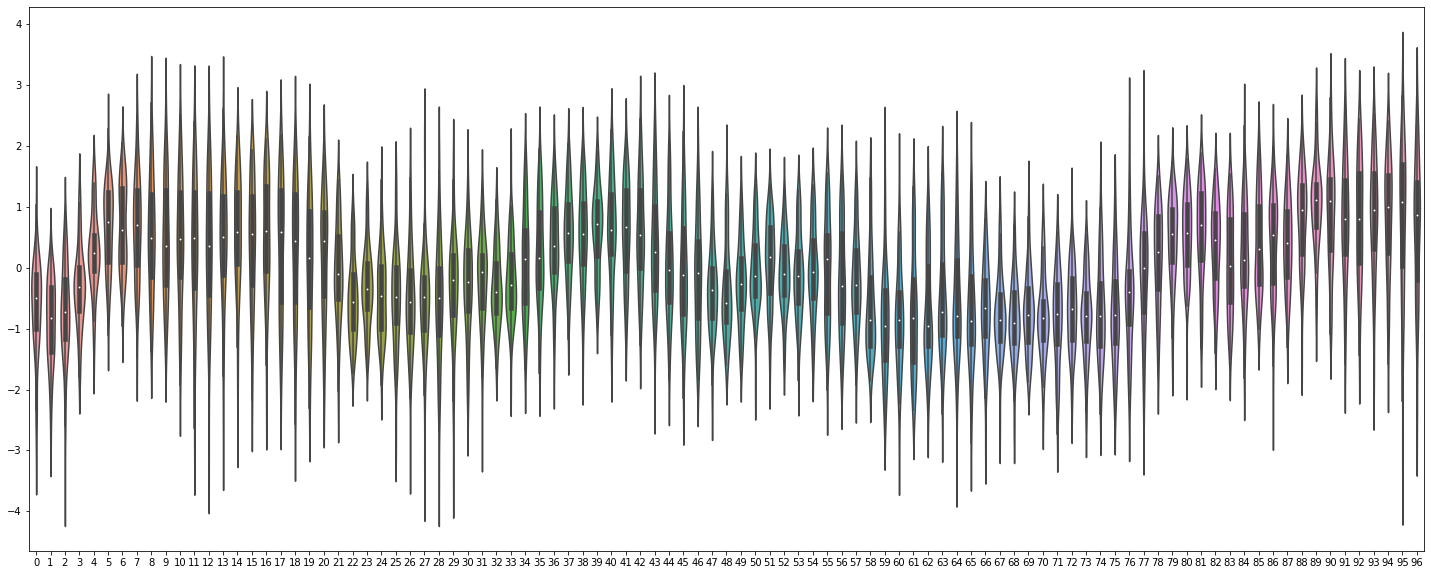

In [17]:
plt.figure(figsize=(25, 10))

sns.violinplot(cmvn_features.transpose(0, 1))

plt.show()

### Full

In [18]:
full_features = dataset.normalize_features(features, normalization = "full")

In [19]:
df = pd.DataFrame(full_features.transpose(0, 1))
df_describe = df.describe()
df_describe

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-0.211275,-0.316842,-0.209122,-0.175071,0.158406,0.289809,0.323803,0.264599,0.197229,0.178591,...,0.216355,0.368723,0.384853,0.314475,0.299070,0.331367,0.340473,0.357033,0.241468,0.246379
std,0.244470,0.244857,0.229717,0.370662,0.406251,0.302356,0.351182,0.334690,0.345859,0.367251,...,0.389055,0.330687,0.266219,0.316849,0.361101,0.390666,0.375650,0.391489,0.397951,0.427193
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.929164,-0.486650,-0.463788,-0.598946,-0.505038,-0.528358,...,-0.697970,-0.662899,-0.347647,-0.390710,-0.599754,-0.586116,-0.744317,-0.657159,-1.000000,-0.923629
25%,-0.325372,-0.485712,-0.329909,-0.392940,-0.029218,0.043266,0.041318,0.015354,-0.058029,-0.105087,...,-0.086710,0.102949,0.247619,0.104569,0.085815,0.029015,0.119733,0.097902,0.010277,-0.074285
50%,-0.161522,-0.291982,-0.203558,-0.172531,0.145753,0.328281,0.300542,0.282505,0.178195,0.132954,...,0.219200,0.428257,0.412434,0.392240,0.303089,0.328049,0.374316,0.415387,0.338491,0.324350
75%,-0.031738,-0.109989,-0.051893,0.006564,0.331479,0.542782,0.637615,0.515291,0.445319,0.480436,...,0.502906,0.606180,0.510775,0.520453,0.544633,0.634694,0.618832,0.627955,0.537773,0.526556
max,0.334815,0.140725,0.227032,0.716863,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.889843,1.000000


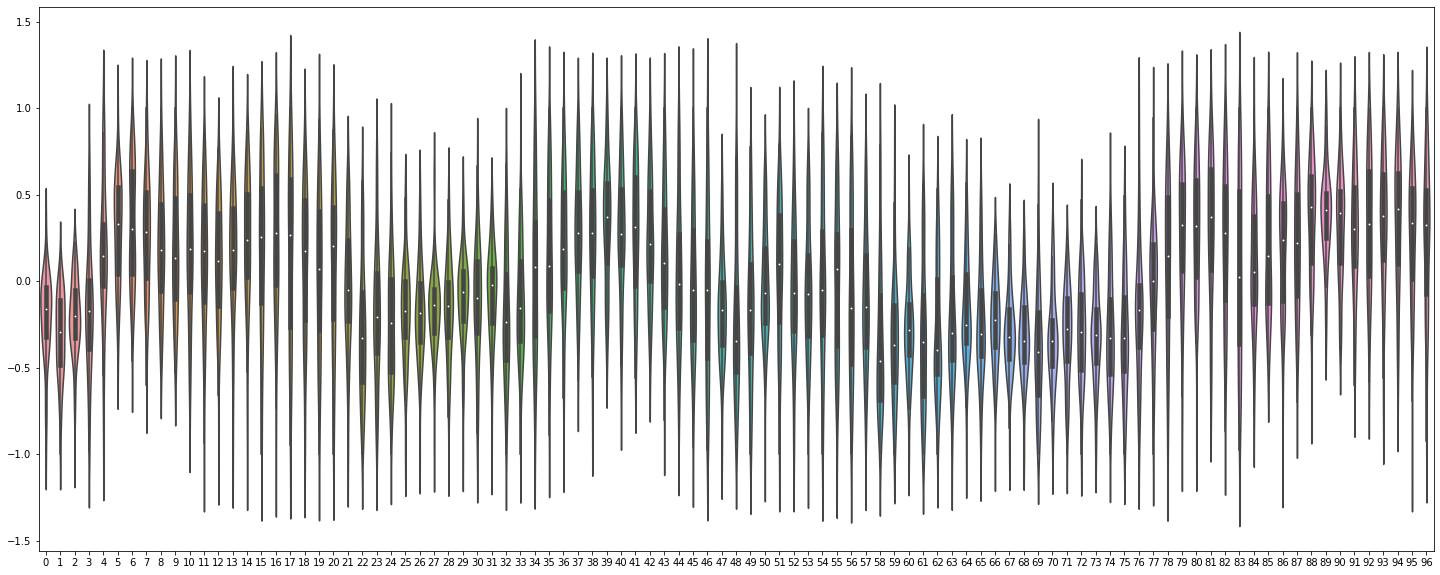

In [20]:
plt.figure(figsize=(25, 10))

sns.violinplot(full_features.transpose(0, 1))

plt.show()